In [71]:
from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(4)

In [72]:
from __future__ import print_function
from rdkit.Chem.Draw import IPythonConsole, ReactionToImage, MolToImage, MolsToGridImage
import rdkit.Chem as Chem
import rdkit.Chem.AllChem as AllChem
from rdkit import DataStructs
import pandas as pd
import numpy as np
from tqdm import tqdm
import json
import sys
import time
sys.path.append('../../')
from retrosim.utils.draw import ReactionStringToImage, TransformStringToImage
from retrosim.utils.generate_retro_templates import process_an_example
from retrosim.data.get_data import get_data_df, split_data_df
from rdchiral.main import rdchiralRun, rdchiralReaction, rdchiralReactants

from joblib import Parallel, delayed
import multiprocessing
num_cores = multiprocessing.cpu_count()

In [3]:
data = get_data_df('../data/data_processed.csv')
split_data_df(data) # 80/10/10 within each class

15151 rows with class value 1
11896 rows with class value 2
5662 rows with class value 3
909 rows with class value 4
672 rows with class value 5
8237 rows with class value 6
4614 rows with class value 7
811 rows with class value 8
1834 rows with class value 9
230 rows with class value 10
train    40008
test      5007
val       5001
Name: dataset, dtype: int64


## Select one set of settings to test

In [73]:
similarity_metric = DataStructs.BulkTanimotoSimilarity # BulkDiceSimilarity or BulkTanimotoSimilarity
similarity_label = 'Tanimoto'
getfp = lambda smi: AllChem.GetMorganFingerprint(Chem.MolFromSmiles(smi), 2, useFeatures=True)
getfp_label = 'Morgan2Feat'

### Only get new FPs if necessary - is a little slow

In [74]:
try:
    if prev_FP != getfp:
        raise NameError
except NameError:
    all_fps = []
    for smi in tqdm(data['prod_smiles']):
        all_fps.append(getfp(smi))
    data['prod_fp'] = all_fps
    prev_FP = getfp

100%|██████████| 50016/50016 [01:03<00:00, 786.27it/s]


### Get the training data subset of the full data

In [78]:
datasub = data.loc[data['dataset'] == 'train']
fps = list(datasub['prod_fp'])
print(len(fps))

40008


### Define the function for processing

In [81]:
from rdkit.Chem.Draw import IPythonConsole, ReactionToImage, MolToImage
from IPython.display import SVG, display, clear_output
sys.path.append('../../')
from retrosim.utils.generate_retro_templates import process_an_example
from collections import defaultdict

draw = True
debug = False
   
def do_one(prod_smiles, draw=draw, debug=debug):
    global jx_cache
    
    rec_for_printing = ''
    
    ex = Chem.MolFromSmiles(prod_smiles)
    rct = rdchiralReactants(prod_smiles)
    fp = getfp(prod_smiles)
    
    start_time = time.time()
    sims = similarity_metric(fp, [fp_ for fp_ in datasub['prod_fp']])
    print('took {:.3f} seconds to get similarity'.format(time.time() - start_time))
    js = np.argsort(sims)[::-1]

    #temp1 = process_an_example(datasub_val['rxn_smiles'][ix], super_general=True)
    #print('TRUE (val) template:')
    #print(temp1)
    if draw: 
        display(MolToImage(ex))
    
    # Get probability of precursors
    probs = {}
    
    start_time = time.time()
    for j in js[:100]:
        jx = datasub.index[j]
        
        rec_for_printing += '\nPrecedent sim {}, rxn_smiles {}\n'.format(sims[j], datasub['rxn_smiles'][jx])
        if jx in jx_cache:
            (template, rcts_ref_fp) = jx_cache[jx]
        else:
            template = '(' + process_an_example(datasub['rxn_smiles'][jx], super_general=True).replace('>>', ')>>')
            rcts_ref_fp = getfp(datasub['rxn_smiles'][jx].split('>')[0])
            jx_cache[jx] = (template, rcts_ref_fp)
            
        rxn = rdchiralReaction(template)
        try:
            outcomes = rdchiralRun(rxn, rct, combine_enantiomers=False)
        except Exception as e:
            print(e)
            outcomes = []
            
        for precursors in outcomes:
            precursors_fp = getfp(precursors)
            precursors_sim = similarity_metric(precursors_fp, [rcts_ref_fp])[0]
            if draw:
                rec_for_printing += 'prec sim {} smiles {}\n'.format(precursors_sim, precursors)
            if precursors in probs:
                probs[precursors] = max(probs[precursors], precursors_sim * sims[j])
            else:
                probs[precursors] = precursors_sim * sims[j]
    print('took {:.3f} seconds to apply <= 100 templates'.format(time.time() - start_time))

        
    testlimit = 50
    mols = []
    legends = []

    found_rank = 9999
    for r, (prec, prob) in enumerate(sorted(probs.iteritems(), key=lambda x:x[1], reverse=True)[:testlimit]):
        mols.append(Chem.MolFromSmiles(prec))
        legends.append('overall score: {:.3f}'.format(prob))

    if draw: 
        img=MolsToGridImage(mols[:9],molsPerRow=3,subImgSize=(300,300),legends=legends[:9])
        display(img)
        for mol in mols[:9]:
            print(Chem.MolToSmiles(mol, True))
    if debug:
        print(rec_for_printing)
        
    return [Chem.MolToSmiles(x, True) for x in mols]

## Enter SMILES string of molecule to test, call do_one

took 0.138 seconds to get similarity


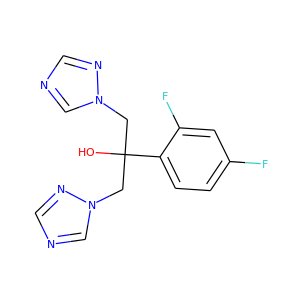

took 0.361 seconds to apply <= 100 templates


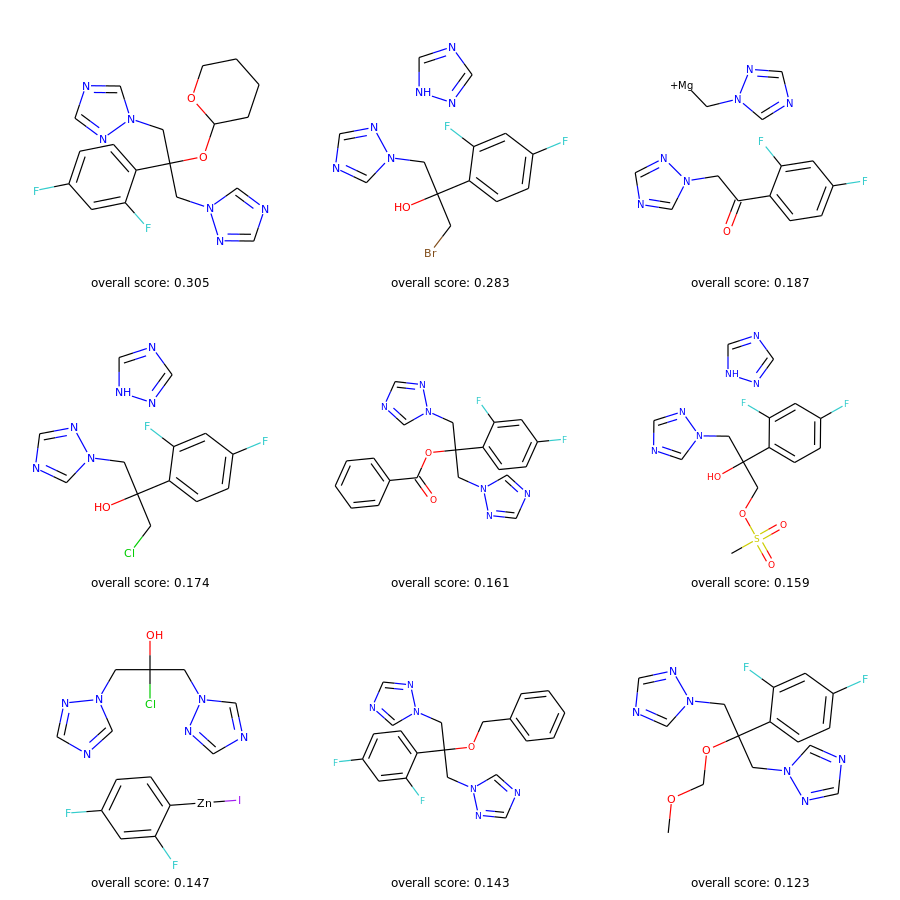

Fc1ccc(C(Cn2cncn2)(Cn2cncn2)OC2CCCCO2)c(F)c1
OC(CBr)(Cn1cncn1)c1ccc(F)cc1F.c1nc[nH]n1
O=C(Cn1cncn1)c1ccc(F)cc1F.[Mg+]Cn1cncn1
OC(CCl)(Cn1cncn1)c1ccc(F)cc1F.c1nc[nH]n1
O=C(OC(Cn1cncn1)(Cn1cncn1)c1ccc(F)cc1F)c1ccccc1
CS(=O)(=O)OCC(O)(Cn1cncn1)c1ccc(F)cc1F.c1nc[nH]n1
Fc1ccc([Zn]I)c(F)c1.OC(Cl)(Cn1cncn1)Cn1cncn1
Fc1ccc(C(Cn2cncn2)(Cn2cncn2)OCc2ccccc2)c(F)c1
COCOC(Cn1cncn1)(Cn1cncn1)c1ccc(F)cc1F


In [82]:
do_one('OC(Cn1cncn1)(Cn1cncn1)c1ccc(F)cc1F');